# Emotion Recognition from Faces with CNN - Training & Evaluation

In this series we will build a model that will guess the emotion of a person from a facial expression. The model will be trained only with the seven basic emtotions identified by Ekman: anger, disgust, contempt, happiness, sadness, fear, surprise.

Moreover, the model will look only at photos of real people (no cartoon or generated images), to capture microexpressions, which are crucual to give high accuracy to such a model. In fact, humans heavily rely on microexpressions to distinguish between different emotions in the arc of milliseconds (e.g., fear from surprise, disgust from contempt), and taking those out of the equations would mean removing key elememnts. A challenge might be increasing the quality of the images used for training, then burdening the computational power with an heavier dataset. Feature engineering might be key in selecting the parts of the images that are the most relevant, eliminating everything else.

Finally we will build different Convolutional Neural Networks and evaluate the different models. Since the whole process will take a significant amount of code, the work will be divided into different notebooks linking to each other.

The first notebook focused in loading, cleaning, and augmenting the data. Access the first notebook below:
- [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda)

This second notebook of the series will focus on builidng deep neaural networks with Pytorch. After that we will train, test, and evaluate the models to select what we think is the best in detecting emotions from facial expressions. After saving the model we will drive some conclusions, underline the limitations of the model, and outline the next steps.

Happy modelling!

## Table of contents

1. [Load the libraries](#load-the-data)
2. [Load the data](#load-the-libraries)
3. [Split the data](#split-the-data)
4. [Build the models](#build-the-models)    
5. [Train the models](#train-the-models)

    5.1 [Define the hyperparameters](#define-the-hyperparameters)

    5.2 [Helper functions for training, testing, and plotting](#helper-functions-for-training-testing-and-plotting)
    
    5.3 [Train the models](#train-the-models)
    
    5.4 [Test the models](#test-the-models)

    5.5 [Table with the results of the different models](#table-with-the-results-of-the-different-models)

    5.6 [Confusion matrix of the best model](#confusion-matrix-of-the-best-model)

6. [Conclusions](#conclusions)

## Load the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os,cv2
import pickle
import random
from hashlib import md5
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

## Load the data

In [2]:
# Load the data from a pickle file
balanced_data = pd.read_pickle('balanced_images_labels.pkl')

Show the properties of the data to assure the data has been loaded correctly.

In [3]:
#See how many elements we have for each class, like we did in the previous notebook.
def count_items_in_classes_2(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Count the number of items in each class
    for label, img_list in balanced_img_data_dict.items():
        print(f'{label}: {len(img_list)} images')

In [4]:
# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the verification function
count_items_in_classes_2(dataset_file)

Neutral: 9111 images
Sadness: 9111 images
Surprise: 9111 images
Happiness: 9111 images
Anger: 9111 images
Fear: 9111 images
Disgust: 9111 images
Contempt: 9111 images


In [5]:
#Inspect the shape of the data
def inspect_balanced_dataset(file_path):
    # Load the balanced dataset
    with open(file_path, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)
    
    # Initialize lists to collect all images and labels
    all_images = []
    all_labels = []

    # Iterate through the dictionary to collect data
    for label, img_list in balanced_img_data_dict.items():
        all_images.extend(img_list)
        all_labels.extend([label] * len(img_list))
    
    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    # Print the required information
    print(f'Loaded data shape: {all_images.shape}')
    print(f'Loaded labels shape: {all_labels.shape}')
    print(f'Unique labels: {set(all_labels)}')

# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the inspection function
inspect_balanced_dataset(dataset_file)

Loaded data shape: (72888, 48, 48)
Loaded labels shape: (72888,)
Unique labels: {'Contempt', 'Neutral', 'Sadness', 'Happiness', 'Disgust', 'Anger', 'Fear', 'Surprise'}


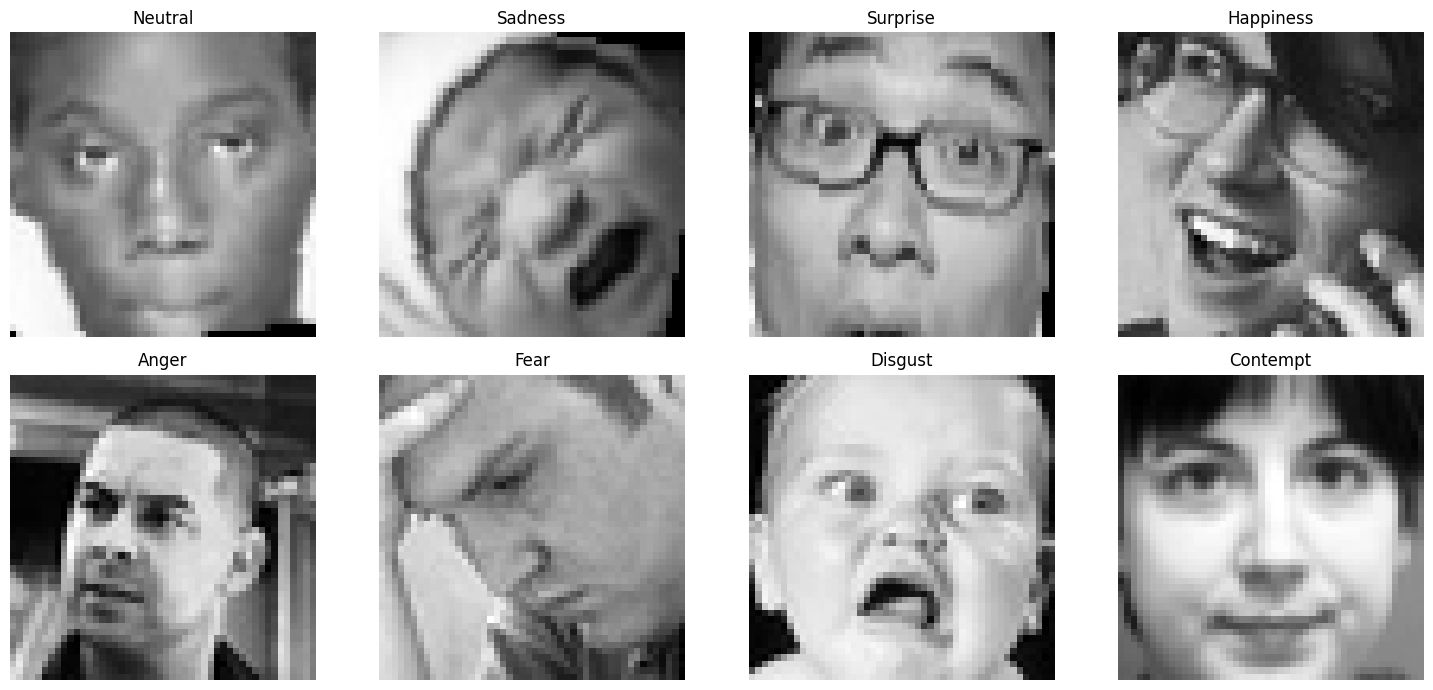

In [7]:
# Visualize a few samples to ensure the data is labelled correctly
with open(dataset_file, 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i, label in enumerate(balanced_img_data_dict.keys()):
    img_data = balanced_img_data_dict[label]
    img_idx = random.randint(0, len(img_data) - 1)
    img = img_data[img_idx]
    ax = axs[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

It looks like the data has been uploaded correctly.

## Split the data

First of all we want to map the each label (string) into a corrresponding integer in a dictionary. Then we want to combine images and corresponding labels in separate lists and convert them into numpy arrays.

In [6]:
# Load the balanced dataset
with open('balanced_images_labels.pkl', 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

# Initialize lists to collect all images and labels
all_images = []
all_labels = []

# Iterate through the dictionary to collect data
for label, img_list in balanced_img_data_dict.items():
    all_images.extend(img_list)
    all_labels.extend([label] * len(img_list))

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Add channel dimension to images
all_images = np.expand_dims(all_images, axis=1)

# Print the new shape
print(f'Images shape with channel dimension: {all_images.shape}')

Images shape with channel dimension: (72888, 1, 48, 48)


In [7]:
# Encode labels as integers
label_to_int = {label: idx for idx, label in enumerate(set(all_labels))}
all_labels_int = np.array([label_to_int[label] for label in all_labels])

# Print the encoded labels
print("Label encoding:")
for label, idx in label_to_int.items():
    print(f'{label}: {idx}')



# Encode labels as integers
label_to_int = {label: idx for idx, label in enumerate(set(all_labels))}
all_labels_int = np.array([label_to_int[label] for label in all_labels])

# Print the encoded labels
print("Label encoding:")
for label, idx in label_to_int.items():
    print(f'{label}: {idx}')



Label encoding:
Contempt: 0
Neutral: 1
Sadness: 2
Happiness: 3
Disgust: 4
Anger: 5
Fear: 6
Surprise: 7


In [16]:
# Create the reverse mapping
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Save the label mapping dictionaries for later use
with open('label_mapping.pkl', 'wb') as f:
    pickle.dump({'label_to_int': label_to_int, 'int_to_label': int_to_label}, f)
print('label_mapping.pkl has been saved')

label_mapping.pkl has been saved


In [8]:
# Convert to PyTorch tensors
all_images_tensor = torch.tensor(all_images, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels_int, dtype=torch.int64)

# Combine into a dataset
dataset = TensorDataset(all_images_tensor, all_labels_tensor)

Now we want to split the dataset into train (used to train the model), validation (used to finetune hyperparameters within the training), and test (used to evaluate the model at the end) datasets. Whereas the training and valdiation datasets will be iteratively used during the training process, the test set is separated (to avoid data leakage), and is used to test the effectiveness of the model on new data (once the full training has been completed).

In [9]:
# Calculate lengths for train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print out the sizes of the resulting datasets
print(f'Training data size: {len(train_dataset)}')
print(f'Validation data size: {len(val_dataset)}')
print(f'Test data size: {len(test_dataset)}')

Training data size: 51021
Validation data size: 10933
Test data size: 10934


As a final step we want to create dataloaders, which are utilities responsible of loading the data into the model in batches. We also want to save each dataset into a pickle file, so we can easily load them without having to run the code above each time we open this notebook.

In [16]:
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Verify the shapes
for images, labels in train_loader:
    print(f'Batch images shape: {images.shape}')
    print(f'Batch labels shape: {labels.shape}')
    break

Batch images shape: torch.Size([32, 1, 48, 48])
Batch labels shape: torch.Size([32])


In [14]:
# Save the datasets
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
print('train_dataset.pkl has been saved')

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)
print('val_dataset.pkl has been saved')

with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)
print('test_dataset.pkl has been saved')

train_dataset.pkl has been saved
val_dataset.pkl has been saved
test_dataset.pkl has been saved


In [8]:
# Load the data from a pickle file
train_dataset = pd.read_pickle('train_dataset.pkl')
val_dataset = pd.read_pickle('val_dataset.pkl')
test_dataset = pd.read_pickle('test_dataset.pkl')
label_mapping = pd.read_pickle('label_mapping.pkl')

## Build the models

#### Model 1

Even if the images are small, we want to be avle to capture details and microexpressions, so we are adding 4 convolutional layers to the model. This number can be empirically adjusted. Too many convolutional layers will lead to overfitting, while too few convolutional layers will lead to underfitting.

In [20]:
# Let's build our model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Adjust input size
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        x = x.view(-1, 256 * 3 * 3)  # Adjust flatten size
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        return x

In [21]:
model_1 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_1.to(device)

# Summarize the model
summary(model_1, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 2

Now we want to make a deep learning model and add a few hidden layers to capture more complex relationships and patterns. Precisely, whereas convolutional layers focus on feature extraction by applying convolution operations on input data, hidden layers focus on transforming and learning representations from these extracted features. 

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x


In [23]:
model_2 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_2.to(device)

# Summarize the model
summary(model_2, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 3

In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.10)
        self.dropout2 = nn.Dropout(p=0.10)
        self.dropout3 = nn.Dropout(p=0.10)
        self.dropout4 = nn.Dropout(p=0.10)
        self.dropout5 = nn.Dropout(p=0.10)
        self.dropout6 = nn.Dropout(p=0.10)
        self.dropout7 = nn.Dropout(p=0.10)
        self.dropout8 = nn.Dropout(p=0.10)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)  # Final layer to output 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)  # No activation function here to return logits
        
        return x


In [25]:
model_3 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_3.to(device)

# Summarize the model
summary(model_3, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 4

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.10)
        self.dropout2 = nn.Dropout(p=0.10)
        self.dropout3 = nn.Dropout(p=0.10)
        self.dropout4 = nn.Dropout(p=0.10)
        self.dropout5 = nn.Dropout(p=0.10)
        self.dropout6 = nn.Dropout(p=0.10)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 8)  # Adding the final fully connected layer for 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # Output layer without activation
        
        return x


In [27]:
model_4 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_4.to(device)

# Summarize the model
summary(model_4, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 5

In [28]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Directly map to output classes
      
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the final layer
        
        return x


In [29]:
model_5 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_5.to(device)

# Summarize the model
summary(model_5, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 6

Let's try to increase the dropout rate to reduce the gap between training and validation accuracy.

In [51]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Directly map to output classes
      
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the final layer
        
        return x

In [52]:
model_6 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_6.to(device)

# Summarize the model
summary(model_6, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 7

Let's see how removing a convolutional layer will change performance.

In [57]:
# Model with 3 convolutional layers
class CNNModel3Conv(nn.Module):
    def __init__(self):
        super(CNNModel3Conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjust input size according to final output size after conv layers
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 8)  # Output 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))  # 12x12 -> 6x6
        x = self.dropout3(x)
        
        x = x.view(-1, 128 * 6 * 6)  # Flatten the tensor according to the output size from conv layers
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        return x


In [58]:
model_7 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_7.to(device)

# Summarize the model
summary(model_7, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 8

Since reducing the number of convolutional layers has reduced the performance of the model, and since adding a convolutional layer would make the model deal with fractional sizes (1.5X1.5 pixel), we shall try adding a hidden layer to see if the performance improves from Model 1 (our best performing model so far). If it doesn't improve then we can consider tweaking other hyperparameters such as the activation functions, the weight decay, learning rate, and the betas.

In [62]:
# Model with an additional hidden layer
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Adjust input size
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)  # New hidden layer
        self.dropout6 = nn.Dropout(p=0.25)  # Dropout for new hidden layer
        self.fc3 = nn.Linear(256, 8)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))  # 12x12 -> 6x6
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))  # 6x6 -> 3x3
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))  # New hidden layer
        x = self.dropout6(x)  # Dropout for new hidden layer
        x = self.fc3(x)  # Output layer
        return x

In [63]:
model_8 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_8.to(device)

# Summarize the model
summary(model_8, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

#### Model 9

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)
        self.dropout8 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [7]:
model_9 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_9.to(device)

# Summarize the model
summary(model_9, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

## Train the models

### Define the hyperparameters

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam  # Define optimizer without specific parameters to accomodate for different models
optimizer_2 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
checkpoint_interval = 5  # Save model weights every 5 epochs

# Set number of epochs
num_epochs = 50

### Helper functions for training, testing, and plotting

In [11]:
#Train the model
def train_model(model, model_name, criterion, optimizer, train_loader,
                val_loader, device, num_epochs, patience,
                checkpoint_interval):
    """
    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - model_name (str): The name to use for saving the model and accuracies.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - num_epochs (int): Number of epochs to train the model.
    - patience (int): Number of epochs to wait for improvement in validation accuracy before stopping early.
    - checkpoint_interval (int): Interval (in epochs) at which to save model checkpoints.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    """
    model = model.to(device)
    model.train()  # Set the model to training mode

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct / total
        train_accuracies.append(epoch_train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Accuracy: {epoch_train_accuracy}%')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracies.append(epoch_val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f'Validation Loss: {val_losses[-1]}, Accuracy: {epoch_val_accuracy}%')

        # Check for early stopping
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch + 1}. Best validation accuracy: {best_val_accuracy}%')
            model.load_state_dict(best_model_wts)
            break

        # Save model checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'{model_name}_checkpoint_epoch_{epoch + 1}.pth'
            torch.save(model.state_dict(), checkpoint_filename)
            print(f'Checkpoint saved at epoch {epoch + 1}')

    # Load the best model weights before early stopping
    model.load_state_dict(best_model_wts)

    # Save the best model weights
    model_filename = f'{model_name}_best_model.pth'
    torch.save(model.state_dict(), model_filename)
    print(f'Best model saved as {model_filename}')

    # Save the accuracies and model name
    with open(f'{model_name}_accuracies.pkl', 'wb') as f:
        pickle.dump((model_name, train_accuracies, val_accuracies), f)

    return train_losses, train_accuracies, val_losses, val_accuracies



In [12]:
#Test the model
def evaluate_model(model, criterion, test_loader, device, model_name):
    """
    Args:
    - model (torch.nn.Module): The trained neural network model.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - model_name (str): The name or identifier of the model.

    Returns:
    - test_loss (float): Average loss on the test set.
    - test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            test_loss += loss.item()  # Accumulate test loss

            _, predicted = torch.max(outputs.data, 1)  # Get predictions
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    test_accuracy = 100 * correct / total

    # Save the test results in a pickle file
    test_results = {
        'test_loss': test_loss / len(test_loader),
        'test_accuracy': test_accuracy
    }
    output_pickle_file = f'{model_name}_test_results.pkl'
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(test_results, f)

    return test_loss / len(test_loader), test_accuracy

In [13]:
# Plot the model performance after training
def plot_training_progress(training_results):
  
    """
    Plot training and validation accuracies across epochs for multiple models.

    Args:
    - training_results (list of tuples): List of tuples containing model names and their respective training and validation accuracies.
      Each tuple should be in the form: (model_name, train_accuracies, val_accuracies).
    """
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation accuracies
    for result in training_results:
        model_name, train_accuracies, val_accuracies = result
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label=f'Training Accuracy - {model_name}')
        plt.plot(epochs, val_accuracies, label=f'Validation Accuracy - {model_name}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [14]:
#Plot the results after testing
def plot_training_validation_test(train_accuracies, val_accuracies, test_accuracy, model_names):
    """
    Plot training, validation, and test accuracy across epochs for multiple models.

    Args:
    - train_accuracies (list of lists): List of lists of training accuracies for each epoch for each model.
    - val_accuracies (list of lists): List of lists of validation accuracies for each epoch for each model.
    - test_accuracy (list): List of accuracies on the test set for each model.
    - model_names (list of str): List of model names corresponding to each set of accuracies.
    """
    plt.figure(figsize=(10, 5))

    # Plot training accuracies
    for i in range(len(train_accuracies)):
        plt.plot(range(1, len(train_accuracies[i]) + 1), train_accuracies[i], label=f'Training Accuracy - {model_names[i]}')

    # Plot validation accuracies
    for i in range(len(val_accuracies)):
        plt.plot(range(1, len(val_accuracies[i]) + 1), val_accuracies[i], label=f'Validation Accuracy - {model_names[i]}')

    # Plot test accuracies
    for i in range(len(test_accuracy)):
        plt.axhline(y=test_accuracy[i], color='r', linestyle='--', label=f'Test Accuracy - {model_names[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


### Train the models

#### Train model_1

In [35]:

train_model(model_1, model_name="Model 1", criterion=criterion, optimizer=optimizer(model_1.parameters(), lr=lr),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.7592447733056957, Accuracy: 31.669312635973423%
Validation Loss: 1.4131993194769699, Accuracy: 47.10509466752035%
Epoch [2/50], Loss: 1.241992746924158, Accuracy: 52.668509045295075%
Validation Loss: 1.2024479128463923, Accuracy: 54.82484222079942%
Epoch [3/50], Loss: 1.040072119759168, Accuracy: 60.306540444130846%
Validation Loss: 1.0440461649532207, Accuracy: 60.59635964511113%
Epoch [4/50], Loss: 0.8946877742075248, Accuracy: 65.73959742066992%
Validation Loss: 1.0130276836847003, Accuracy: 61.44699533522363%
Epoch [5/50], Loss: 0.7644447535182989, Accuracy: 71.1667744654162%
Validation Loss: 0.9907354460647929, Accuracy: 62.535443153754684%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 0.6417402473549858, Accuracy: 75.72960153662217%
Validation Loss: 1.0466441697718805, Accuracy: 63.504984908076466%
Epoch [7/50], Loss: 0.5236948530034959, Accuracy: 80.59034515199623%
Validation Loss: 1.134582033282832, Accuracy: 64.34647397786517%
Epoch [8/50], Loss: 0.4167

([1.7592447733056957,
  1.241992746924158,
  1.040072119759168,
  0.8946877742075248,
  0.7644447535182989,
  0.6417402473549858,
  0.5236948530034959,
  0.41672596071954804,
  0.328731564240863,
  0.2602612065332343,
  0.20826773608868304,
  0.19337559887908726,
  0.16547183196066198,
  0.15975088554063702,
  0.1386111697243369,
  0.14075681049621966,
  0.1313567060369963],
 [31.669312635973423,
  52.668509045295075,
  60.306540444130846,
  65.73959742066992,
  71.1667744654162,
  75.72960153662217,
  80.59034515199623,
  84.72393720232846,
  87.98729934732756,
  90.63326865408361,
  92.4874071460771,
  93.11851982517003,
  94.34938554712765,
  94.33566570627781,
  95.22745536151781,
  95.19217577076105,
  95.5469316555928],
 [1.4131993194769699,
  1.2024479128463923,
  1.0440461649532207,
  1.0130276836847003,
  0.9907354460647929,
  1.0466441697718805,
  1.134582033282832,
  1.18985016914139,
  1.331626191560985,
  1.4907524383556077,
  1.6123779188645513,
  1.7667872082245977,
  1.

#### Train model_1 with weight_decay and betas

In [36]:
train_model(model=model_1, model_name="Model_1_w_parameters", criterion=criterion, optimizer=optimizer_2(model_1.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.4256349172711746, Accuracy: 50.953528939064306%
Validation Loss: 1.0506161602965571, Accuracy: 61.986645934327264%
Epoch [2/50], Loss: 0.20004712240215752, Accuracy: 93.18711902941926%
Validation Loss: 1.6509210946615676, Accuracy: 65.12393670538737%
Epoch [3/50], Loss: 0.1535051822072613, Accuracy: 94.55518315987534%
Validation Loss: 1.7842763172604188, Accuracy: 64.81295161437849%
Epoch [4/50], Loss: 0.14468462461909296, Accuracy: 94.97265831716352%
Validation Loss: 1.9404960026343663, Accuracy: 64.92271105826397%
Epoch [5/50], Loss: 0.1392096700574502, Accuracy: 95.21177554340369%
Validation Loss: 2.105916574945924, Accuracy: 64.56599286563615%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 0.13442311777549337, Accuracy: 95.39993336077302%
Validation Loss: 1.9511439101389276, Accuracy: 64.95015091923534%
Epoch [7/50], Loss: 0.12343603111701348, Accuracy: 95.7625291546618%
Validation Loss: 2.221596070810368, Accuracy: 65.12393670538737%
Early stopping at epoch 

([1.4256349172711746,
  0.20004712240215752,
  0.1535051822072613,
  0.14468462461909296,
  0.1392096700574502,
  0.13442311777549337,
  0.12343603111701348],
 [50.953528939064306,
  93.18711902941926,
  94.55518315987534,
  94.97265831716352,
  95.21177554340369,
  95.39993336077302,
  95.7625291546618],
 [1.0506161602965571,
  1.6509210946615676,
  1.7842763172604188,
  1.9404960026343663,
  2.105916574945924,
  1.9511439101389276,
  2.221596070810368],
 [61.986645934327264,
  65.12393670538737,
  64.81295161437849,
  64.92271105826397,
  64.56599286563615,
  64.95015091923534,
  65.12393670538737])

#### Plot model_1

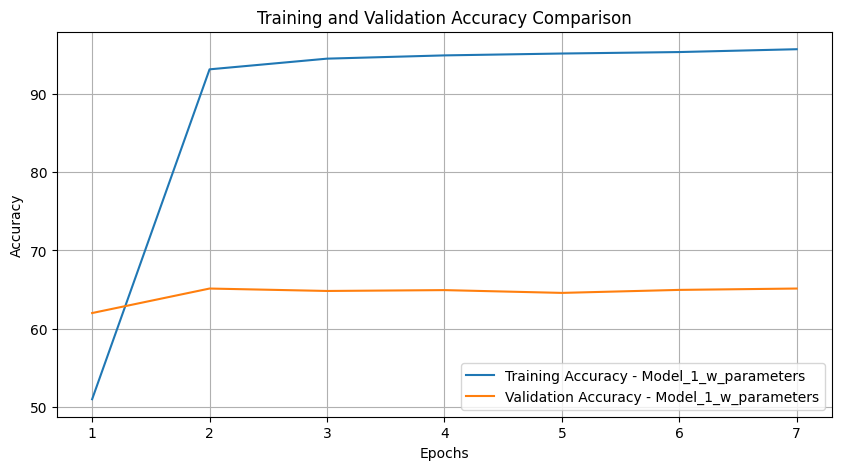

In [37]:
model_name ="Model_1_w_parameters"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

We can see that adding weight decay and betas to the model improve the performance only slightly. A fine tuting of these two hyperparameters could lead to significant improvements. Another action that can lead to significant improvements, is adding layers to the model, such as hidden layers, to capture more complex relationships in the data; and this is what we are going to do next with model_2.

#### Train model_2

In [39]:
train_model(model=model_2, model_name="Model_2", criterion=criterion, optimizer=optimizer_2(model_2.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 2.027202128392402, Accuracy: 16.20117206640403%
Validation Loss: 1.8346256578874867, Accuracy: 24.137931034482758%
Epoch [2/50], Loss: 1.647418348916272, Accuracy: 33.51953117343839%
Validation Loss: 1.5075209729852732, Accuracy: 41.01344553187597%
Epoch [3/50], Loss: 1.376916492807454, Accuracy: 45.61651084847416%
Validation Loss: 1.3305524483061673, Accuracy: 47.89170401536632%
Epoch [4/50], Loss: 1.2402657383287963, Accuracy: 51.077007506712924%
Validation Loss: 1.2478023493847652, Accuracy: 50.27897191987561%
Epoch [5/50], Loss: 1.148322264901523, Accuracy: 54.80096430881402%
Validation Loss: 1.1882910937593694, Accuracy: 53.983353151010704%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.070175249897948, Accuracy: 57.786009682287684%
Validation Loss: 1.1529366539584265, Accuracy: 55.410225921522%
Epoch [7/50], Loss: 1.006119739635611, Accuracy: 60.237941239881614%
Validation Loss: 1.1159137283500873, Accuracy: 56.919418274947404%
Epoch [8/50], Loss: 0.9490238

([2.027202128392402,
  1.647418348916272,
  1.376916492807454,
  1.2402657383287963,
  1.148322264901523,
  1.070175249897948,
  1.006119739635611,
  0.9490238753605785,
  0.9003215594725176,
  0.8455882844132689,
  0.812493636821131,
  0.7481566004431733,
  0.7034814865237867,
  0.6560515545939203,
  0.6000457867653018,
  0.5546548785834476,
  0.5028772664481196,
  0.45465572663702564,
  0.4084479616213368,
  0.3756355724925158,
  0.33454907881475543,
  0.29763156033608607,
  0.2759714518408043,
  0.2524522633574973,
  0.23675769082676373,
  0.21118774040657617,
  0.20932128578190892,
  0.181578930876463,
  0.1755861395029906,
  0.1651245042380985,
  0.1503781494007192,
  0.14842131249475232,
  0.141736671261104,
  0.13501614776839937,
  0.1309325512640213,
  0.12538324245594756],
 [16.20117206640403,
  33.51953117343839,
  45.61651084847416,
  51.077007506712924,
  54.80096430881402,
  57.786009682287684,
  60.237941239881614,
  62.646753297661746,
  64.49109190333392,
  66.868544324

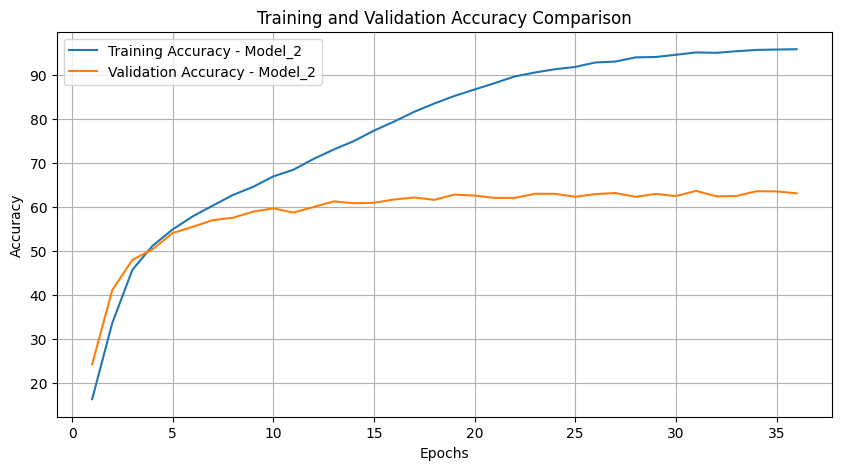

In [40]:
model_name ="Model_2"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_3

The model did better earlier, and now it may be underfitting the data. The hidden layers might be to many for the amount of data. Before reducing the hidden layers, let's try to reduce the amount of dropout to 0.10.

In [41]:
train_model(model=model_3, model_name="Model_3", criterion=criterion, optimizer=optimizer_2(model_3.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 2.068941379490317, Accuracy: 14.005997530428647%
Validation Loss: 2.00998473271989, Accuracy: 18.86947772797951%
Epoch [2/50], Loss: 1.8346144114915854, Accuracy: 25.944219047059054%
Validation Loss: 1.682037655721631, Accuracy: 34.51019848166103%
Epoch [3/50], Loss: 1.5569235331586162, Accuracy: 39.45630230689324%
Validation Loss: 1.486432959810335, Accuracy: 41.90981432360743%
Epoch [4/50], Loss: 1.4240848334605418, Accuracy: 44.136728013955036%
Validation Loss: 1.3928427915824086, Accuracy: 44.73612000365865%
Epoch [5/50], Loss: 1.3559405854503188, Accuracy: 46.690578389290685%
Validation Loss: 1.3481451494303363, Accuracy: 46.702643373273574%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.2956333145826213, Accuracy: 49.00531153838615%
Validation Loss: 1.3141566987274682, Accuracy: 48.42220799414616%
Epoch [7/50], Loss: 1.2498916463418441, Accuracy: 50.632092667725054%
Validation Loss: 1.298517971882346, Accuracy: 48.59599378029818%
Epoch [8/50], Loss: 1.20379

([2.068941379490317,
  1.8346144114915854,
  1.5569235331586162,
  1.4240848334605418,
  1.3559405854503188,
  1.2956333145826213,
  1.2498916463418441,
  1.2037947998525207,
  1.1689644588945802,
  1.12879481173608,
  1.09924885408258,
  1.073184716533344,
  1.0349293249154166,
  1.0097054469734899,
  0.9864582076715451,
  0.9548320264278161,
  0.9266743343078231,
  0.9024766106964279,
  0.8711377032871904,
  0.8413584822771317,
  0.819409933564805,
  0.7851502015672881,
  0.7553263389391586,
  0.7256848712886762,
  0.6951626690764412,
  0.6629149538409373,
  0.6379099986769936,
  0.5994894239128944,
  0.5672427414726687,
  0.5450347467275997,
  0.5218754179658934,
  0.4826081812708729,
  0.4638903375983612,
  0.4380865519183183,
  0.41812148260472337,
  0.39906509098681536,
  0.3705112112656843,
  0.3573056013676627,
  0.3367478776127567,
  0.3304682608331819,
  0.3061955285483393],
 [14.005997530428647,
  25.944219047059054,
  39.45630230689324,
  44.136728013955036,
  46.6905783892

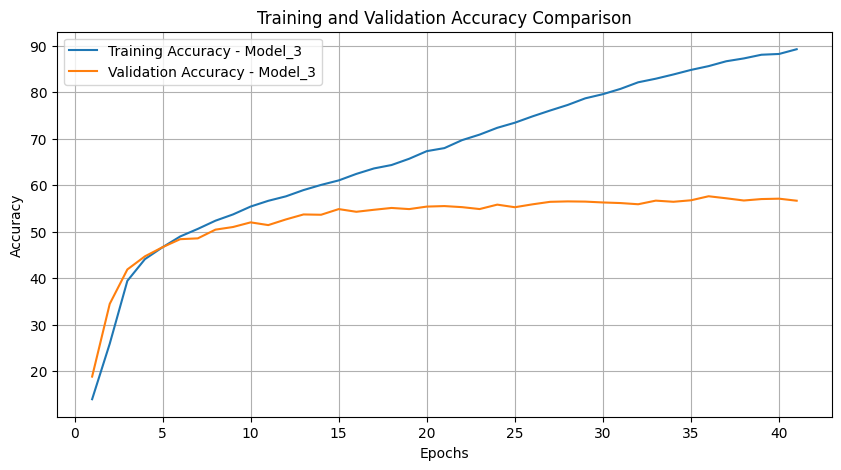

In [42]:
model_name ="Model_3"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_4

In [43]:
train_model(model=model_4, model_name="Model_4", criterion=criterion, optimizer=optimizer_2(model_4.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.8815904670374521, Accuracy: 23.68044530683444%
Validation Loss: 1.597569131363205, Accuracy: 38.25116619409128%
Epoch [2/50], Loss: 1.4649420572672518, Accuracy: 42.382548362438996%
Validation Loss: 1.3523204016406634, Accuracy: 46.24531235708406%
Epoch [3/50], Loss: 1.297322949907249, Accuracy: 48.61135610826914%
Validation Loss: 1.296631977397796, Accuracy: 48.943565352602214%
Epoch [4/50], Loss: 1.186434830991452, Accuracy: 52.88606652162835%
Validation Loss: 1.1858371165063646, Accuracy: 53.47114241287844%
Epoch [5/50], Loss: 1.0999726094422295, Accuracy: 56.44342525626703%
Validation Loss: 1.1561748688681084, Accuracy: 55.31875971828409%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.0196412852191625, Accuracy: 59.95570451382764%
Validation Loss: 1.1052129901292032, Accuracy: 57.898106649592975%
Epoch [7/50], Loss: 0.9501661445653551, Accuracy: 62.789831637953%
Validation Loss: 1.0944620550375932, Accuracy: 58.07189243574499%
Epoch [8/50], Loss: 0.88686179

([1.8815904670374521,
  1.4649420572672518,
  1.297322949907249,
  1.186434830991452,
  1.0999726094422295,
  1.0196412852191625,
  0.9501661445653551,
  0.8868617957288568,
  0.8288193664767526,
  0.7671883806352705,
  0.70674121946003,
  0.647997499885604,
  0.5874535042664101,
  0.5313837011779737,
  0.4816429731147043,
  0.4322104398312987,
  0.38775060299702196,
  0.3516738419085274,
  0.3169689058720318,
  0.2821326370231317,
  0.2627422137974198,
  0.2478723105913186,
  0.22920278762365023,
  0.20296677653108458,
  0.18883900525147637,
  0.18649778368103326,
  0.16849081080004014,
  0.15813186851922761,
  0.15733067577844922,
  0.14248385281304954,
  0.14074275040164075,
  0.12806448087148764,
  0.13046282822715824,
  0.12433996534261117,
  0.1160747835072499,
  0.12026495840020922,
  0.11137086439492373,
  0.10874279828415162,
  0.10452757316942948,
  0.09987068817458848,
  0.09789008582740742,
  0.1036811423708384,
  0.09619010354174727,
  0.09018827129956802,
  0.096018450424

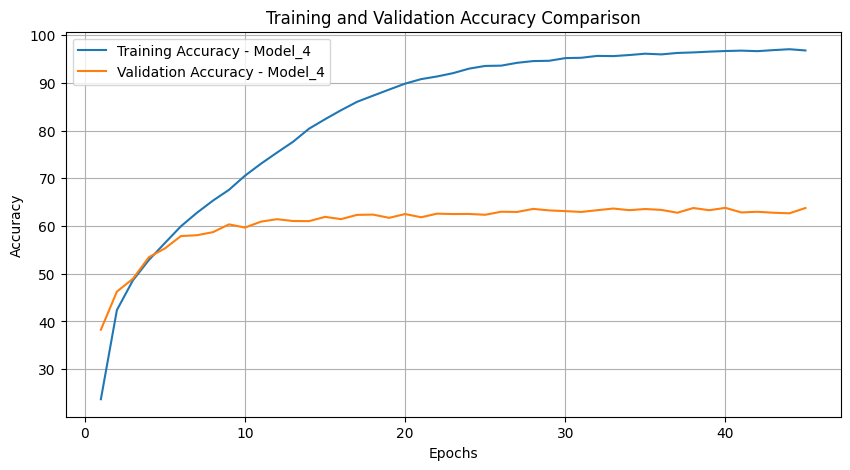

In [44]:
model_name ="Model_4"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_5

In [45]:
train_model(model=model_5, model_name="Model_5", criterion=criterion, optimizer=optimizer_2(model_5.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 2.0792155989285175, Accuracy: 12.771211853942495%
Validation Loss: 2.0631491172383405, Accuracy: 16.098051769871034%
Epoch [2/50], Loss: 1.8146473318805516, Accuracy: 27.355402677328943%
Validation Loss: 1.6086608384087768, Accuracy: 36.10171041800055%
Epoch [3/50], Loss: 1.5389491006498426, Accuracy: 39.064306854040495%
Validation Loss: 1.4960530142337956, Accuracy: 41.13235159608524%
Epoch [4/50], Loss: 1.4063707259007756, Accuracy: 44.401324944630645%
Validation Loss: 1.3550507086410857, Accuracy: 46.18128601481752%
Epoch [5/50], Loss: 1.318456310276701, Accuracy: 47.79404558907117%
Validation Loss: 1.3266119202326614, Accuracy: 47.727064849538095%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.256253385095387, Accuracy: 50.340056055349756%
Validation Loss: 1.2604592850333767, Accuracy: 50.80947589865545%
Epoch [7/50], Loss: 1.1987676971011028, Accuracy: 52.764547931243996%
Validation Loss: 1.2185805309237094, Accuracy: 52.69367968535626%
Epoch [8/50], Loss: 1

([2.0792155989285175,
  1.8146473318805516,
  1.5389491006498426,
  1.4063707259007756,
  1.318456310276701,
  1.256253385095387,
  1.1987676971011028,
  1.1496312993447235,
  1.1092968740059663,
  1.0715832536870784,
  1.0409537014355854,
  1.011852567715331,
  0.9863453391577383,
  0.9603999761017886,
  0.9342084281123171,
  0.907280831351923,
  0.8877810189903343,
  0.8624933332858788,
  0.837413973400959,
  0.8114114418859392,
  0.7861517711679764,
  0.7651209486876162,
  0.7399789681255257,
  0.7147178659244765,
  0.686505069385128,
  0.659818082431267,
  0.6406618754598414,
  0.6135420859420561,
  0.5900313772191075,
  0.5699816368964025,
  0.5430690119726157,
  0.5163901161671058,
  0.4999298532834995],
 [12.771211853942495,
  27.355402677328943,
  39.064306854040495,
  44.401324944630645,
  47.79404558907117,
  50.340056055349756,
  52.764547931243996,
  54.479528037474765,
  56.23566766625507,
  57.427333842927425,
  58.89143685933243,
  59.84006585523608,
  61.014092236530054

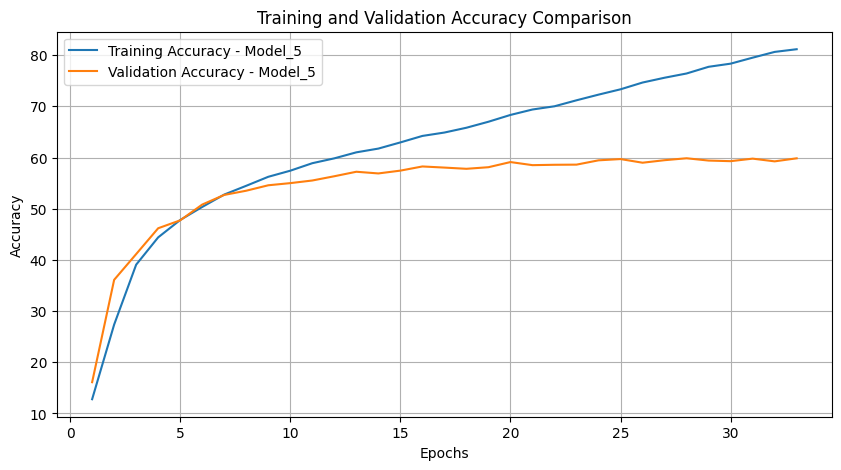

In [46]:
model_name ="Model_5"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_6

In [53]:
train_model(model=model_6, model_name="Model_6", criterion=criterion, optimizer=optimizer_2(model_6.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.983884795855579, Accuracy: 18.952980145430313%
Validation Loss: 1.713684530634629, Accuracy: 30.211286929479556%
Epoch [2/50], Loss: 1.5784916103073048, Accuracy: 36.86913231806511%
Validation Loss: 1.4886939100354735, Accuracy: 41.644562334217504%
Epoch [3/50], Loss: 1.3810747475833354, Accuracy: 45.56163148507477%
Validation Loss: 1.3372334757743523, Accuracy: 47.36120003658648%
Epoch [4/50], Loss: 1.26622686079677, Accuracy: 49.64426412653613%
Validation Loss: 1.271300077612637, Accuracy: 49.940546967895365%
Epoch [5/50], Loss: 1.1803574180901986, Accuracy: 53.078144293526194%
Validation Loss: 1.1960344706711017, Accuracy: 53.20589042348852%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.1066805052906743, Accuracy: 55.839752258873794%
Validation Loss: 1.1638454364405737, Accuracy: 54.25775176072441%
Epoch [7/50], Loss: 1.043543699393078, Accuracy: 58.63467983771388%
Validation Loss: 1.1470700701077778, Accuracy: 56.114515686453856%
Epoch [8/50], Loss: 0.9899

([1.983884795855579,
  1.5784916103073048,
  1.3810747475833354,
  1.26622686079677,
  1.1803574180901986,
  1.1066805052906743,
  1.043543699393078,
  0.9899686446571051,
  0.9415214163382599,
  0.8879702826465559,
  0.8389315952701628,
  0.7981951403954186,
  0.7372920305938182,
  0.6902423588459768,
  0.6395923261078174,
  0.592664930897073,
  0.5408751477081574,
  0.498115541498676,
  0.456991671380765,
  0.4219324225635738,
  0.3780393351815337,
  0.3587032224994655,
  0.3208775090374823],
 [18.952980145430313,
  36.86913231806511,
  45.56163148507477,
  49.64426412653613,
  53.078144293526194,
  55.839752258873794,
  58.63467983771388,
  60.414339193665356,
  62.79375159248153,
  64.9575664922287,
  67.16646086905392,
  68.9186805433057,
  71.77044746280943,
  73.50502734168283,
  75.71784167303659,
  77.64449932380785,
  79.72991513298446,
  81.66441269281276,
  83.43035220791438,
  84.64161815722937,
  86.48007683110876,
  86.97791105623175,
  88.53805295858568],
 [1.7136845306

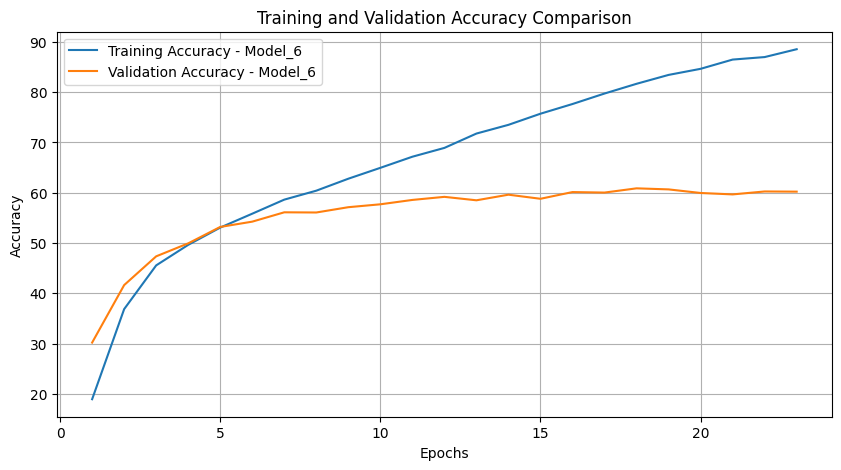

In [54]:
model_name ="Model_6"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_7

In [59]:
train_model(model=model_7, model_name="Model_7", criterion=criterion, optimizer=optimizer_2(model_7.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.9432372880206212, Accuracy: 20.56800141118363%
Validation Loss: 1.72390896186494, Accuracy: 31.01618951797311%
Epoch [2/50], Loss: 1.5773817345266432, Accuracy: 37.5022049744223%
Validation Loss: 1.447210166015123, Accuracy: 43.848897832250984%
Epoch [3/50], Loss: 1.3679114361168074, Accuracy: 46.763097548068444%
Validation Loss: 1.3315939415268034, Accuracy: 47.90085063569011%
Epoch [4/50], Loss: 1.2177148546918433, Accuracy: 52.30591325140628%
Validation Loss: 1.2087840333319546, Accuracy: 52.93149181377481%
Epoch [5/50], Loss: 1.1127787951952237, Accuracy: 56.06318966699986%
Validation Loss: 1.1616271216618388, Accuracy: 54.66020305497119%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.026478047094375, Accuracy: 59.69110758315203%
Validation Loss: 1.1002723457869032, Accuracy: 56.791365590414344%
Epoch [7/50], Loss: 0.9537117585119409, Accuracy: 62.45663550302817%
Validation Loss: 1.112724621044962, Accuracy: 57.57797493826031%
Epoch [8/50], Loss: 0.88975554

([1.9432372880206212,
  1.5773817345266432,
  1.3679114361168074,
  1.2177148546918433,
  1.1127787951952237,
  1.026478047094375,
  0.9537117585119409,
  0.8897555475885218,
  0.8262512697695191,
  0.7637658038856842,
  0.7046859103964414,
  0.640143480635362,
  0.5797513552874233,
  0.5170153673913411,
  0.4644042453982613,
  0.41453224973618796,
  0.3670383542005358,
  0.32828376203728693,
  0.29366052175717294,
  0.27345687528622564,
  0.2451211256853839,
  0.22467380496249958,
  0.20556123973071855,
  0.19027544298650095,
  0.1775303370106183,
  0.16504750749867025,
  0.16293726089004673,
  0.15212139833578403,
  0.14821124007067057,
  0.1350194534101468,
  0.12360003237980403,
  0.12787028243363802,
  0.1282586328197726,
  0.11762937219203289,
  0.11332020385141213],
 [20.56800141118363,
  37.5022049744223,
  46.763097548068444,
  52.30591325140628,
  56.06318966699986,
  59.69110758315203,
  62.45663550302817,
  65.32212226338174,
  68.0758903196723,
  70.62778071774368,
  73.18

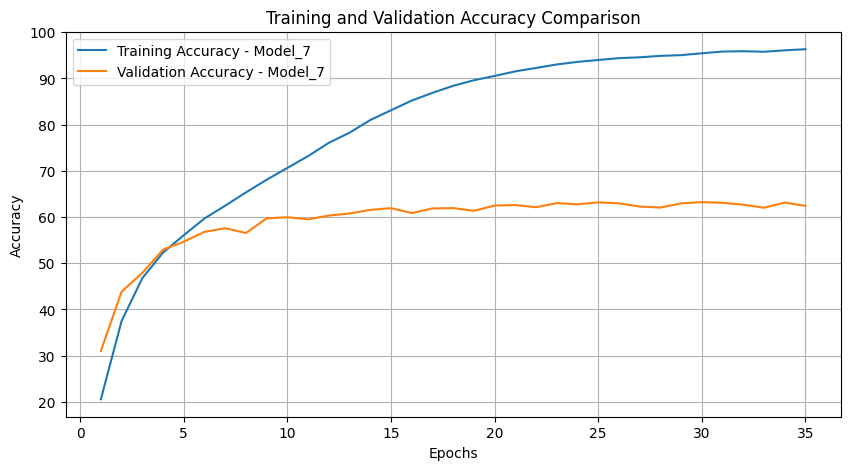

In [60]:
model_name ="Model_7"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_8

In [64]:
train_model(model=model_8, model_name="Model_8", criterion=criterion, optimizer=optimizer_2(model_8.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.8321445851490414, Accuracy: 27.931635993022482%
Validation Loss: 1.5116138221227635, Accuracy: 42.2207994146163%
Epoch [2/50], Loss: 1.3089695689072802, Accuracy: 49.75206287607064%
Validation Loss: 1.183924477525622, Accuracy: 53.91018018842038%
Epoch [3/50], Loss: 1.1109297285633026, Accuracy: 57.26269575272927%
Validation Loss: 1.100495717156003, Accuracy: 58.51093021128693%
Epoch [4/50], Loss: 0.9810796033252369, Accuracy: 62.572274161619724%
Validation Loss: 1.0290009016007708, Accuracy: 60.632946126406296%
Epoch [5/50], Loss: 0.8760065466445816, Accuracy: 66.27859116834244%
Validation Loss: 1.0161668998978988, Accuracy: 61.36467575230952%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 0.7892763910622432, Accuracy: 69.8104701985457%
Validation Loss: 1.0528987741958329, Accuracy: 62.02323241562243%
Epoch [7/50], Loss: 0.7029133154307039, Accuracy: 73.05423257090217%
Validation Loss: 1.0738934267159792, Accuracy: 63.17570657642001%
Epoch [8/50], Loss: 0.620025

([1.8321445851490414,
  1.3089695689072802,
  1.1109297285633026,
  0.9810796033252369,
  0.8760065466445816,
  0.7892763910622432,
  0.7029133154307039,
  0.6200255129311152,
  0.5400542102824184,
  0.4694683242507489,
  0.40432875508144733,
  0.3450332463885363,
  0.30573194059411934],
 [27.931635993022482,
  49.75206287607064,
  57.26269575272927,
  62.572274161619724,
  66.27859116834244,
  69.8104701985457,
  73.05423257090217,
  76.48027282883518,
  79.53783736108662,
  82.6346014386233,
  85.02381372376081,
  87.16802885086533,
  88.74581054859763],
 [1.5116138221227635,
  1.183924477525622,
  1.100495717156003,
  1.0290009016007708,
  1.0161668998978988,
  1.0528987741958329,
  1.0738934267159792,
  1.0661119509335848,
  1.1528853983209844,
  1.20245459684503,
  1.3532586367855295,
  1.5114119579220375,
  1.5467349126150733],
 [42.2207994146163,
  53.91018018842038,
  58.51093021128693,
  60.632946126406296,
  61.36467575230952,
  62.02323241562243,
  63.17570657642001,
  63.66

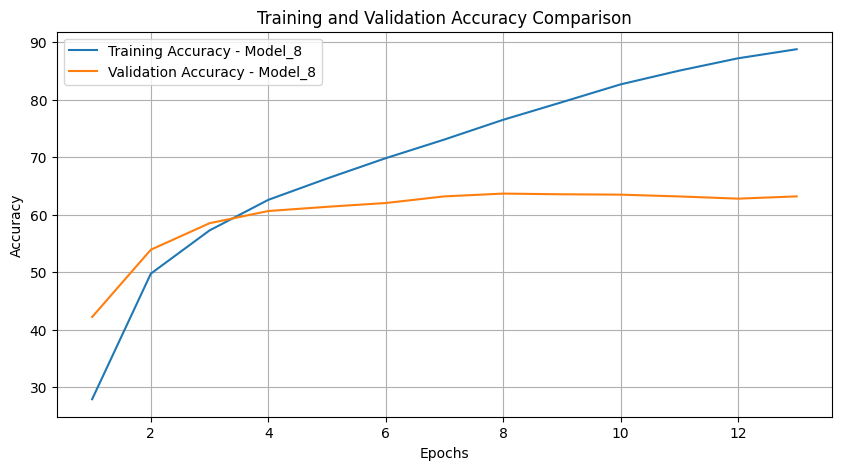

In [65]:
model_name ="Model_8"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_9

In [17]:
train_model(model=model_9, model_name="Model_9", criterion=criterion, optimizer=optimizer_2(model_9.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 2.036005063041998, Accuracy: 17.045922267301698%
Validation Loss: 1.9279931278256646, Accuracy: 20.59818896917589%
Epoch [2/50], Loss: 1.675040677722345, Accuracy: 32.23378608808138%
Validation Loss: 1.4786208458462653, Accuracy: 41.04088539284734%
Epoch [3/50], Loss: 1.3428944033888814, Accuracy: 47.190372591677935%
Validation Loss: 1.2916289428521317, Accuracy: 48.980151833897374%
Epoch [4/50], Loss: 1.1819657819398144, Accuracy: 53.477979655435995%
Validation Loss: 1.208772067089527, Accuracy: 53.51687551449739%
Epoch [5/50], Loss: 1.0824562549591064, Accuracy: 57.4234138883989%
Validation Loss: 1.1873830778208392, Accuracy: 55.099240830513125%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 0.9890752212941459, Accuracy: 60.89649360067423%
Validation Loss: 1.1205301903493223, Accuracy: 57.404189152108295%
Epoch [7/50], Loss: 0.9096472992792398, Accuracy: 63.83645949706983%
Validation Loss: 1.0871268983124291, Accuracy: 58.88594164456234%
Epoch [8/50], Loss: 0.831

([2.036005063041998,
  1.675040677722345,
  1.3428944033888814,
  1.1819657819398144,
  1.0824562549591064,
  0.9890752212941459,
  0.9096472992792398,
  0.8318516745462686,
  0.7551170254388947,
  0.6856829171270412,
  0.6063900819299363,
  0.5401228417516876,
  0.47649874941775794,
  0.41146235786448454,
  0.36095237341887526,
  0.3224369172941088,
  0.2778943778205441,
  0.24269894049108776,
  0.22346755330769058,
  0.1957660367910905],
 [17.045922267301698,
  32.23378608808138,
  47.190372591677935,
  53.477979655435995,
  57.4234138883989,
  60.89649360067423,
  63.83645949706983,
  67.06650202857647,
  70.4376629231101,
  73.4854275690402,
  76.72918994139668,
  79.63975617882832,
  82.19360655416398,
  85.02381372376081,
  87.07982987397347,
  88.48709354971483,
  90.33927206444405,
  91.54269810470198,
  92.23849003351562,
  93.29687775621802],
 [1.9279931278256646,
  1.4786208458462653,
  1.2916289428521317,
  1.208772067089527,
  1.1873830778208392,
  1.1205301903493223,
  1.

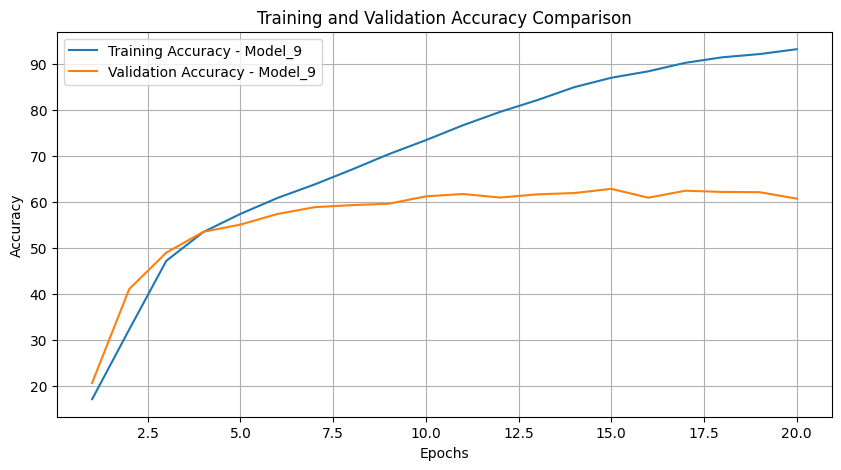

In [19]:
model_name ="Model_9"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

### Test the models

#### Test model 1

In [85]:
model_name = "Model 1"
evaluate_model(model_1, criterion, test_loader, device, model_name)

(1.5665786319483093, 65.95024693616243)

#### Test model 2

In [88]:
model_name = "Model 2"
evaluate_model(model_2, criterion, test_loader, device, model_name)

(1.8254068302567938, 63.33455277117249)

#### Test model 3

In [89]:
model_name = "Model 3"
evaluate_model(model_3, criterion, test_loader, device, model_name)

(1.7924511096282312, 56.914212548015364)

#### Test model 4

In [90]:
model_name = "Model 4"
evaluate_model(model_4, criterion, test_loader, device, model_name)

(2.17419102753115, 63.73696725809402)

#### Test model 5

In [91]:
model_name = "Model 5"
evaluate_model(model_5, criterion, test_loader, device, model_name)

(1.2912408848952133, 59.465886226449605)

#### Test model 6

In [92]:
model_name = "Model 6"
evaluate_model(model_6, criterion, test_loader, device, model_name)

(1.3415102043695617, 60.71885860618255)

#### Test model 7

In [93]:
model_name = "Model 7"
evaluate_model(model_7, criterion, test_loader, device, model_name)

(1.8742047422810604, 63.133345527711725)

Model 1, 2, 4 performed best, especially 1; so let's see what trait those models share.

#### Test model 8

In [94]:
model_name = "Model 8"
evaluate_model(model_8, criterion, test_loader, device, model_name)

(1.075719740307122, 63.02359612218767)

#### Test model 9

In [21]:
model_name = "Model 9"
evaluate_model(model_9, criterion, test_loader, device, model_name)

(1.438141121153246, 63.526614230839584)

### Table with the results of the different models

Before making our table we want to inspect the structure of the pickle files where we saved our accuracies. In this way we will know how to load the data.

In [9]:
# Function to inspect the structure of the pickle file
def inspect_pickle_file(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    print(f"Data from {pickle_file}:")
    print(data)
    return data

# Inspect one of the pickle files with the accuracies
sample_file_1 = 'Model 1_accuracies.pkl'
sample_file_2 = 'Model 1_test_results.pkl'
data_1 = inspect_pickle_file(sample_file_1)
data_2 = inspect_pickle_file(sample_file_2)

Data from Model 1_accuracies.pkl:
('Model 1', [31.669312635973423, 52.668509045295075, 60.306540444130846, 65.73959742066992, 71.1667744654162, 75.72960153662217, 80.59034515199623, 84.72393720232846, 87.98729934732756, 90.63326865408361, 92.4874071460771, 93.11851982517003, 94.34938554712765, 94.33566570627781, 95.22745536151781, 95.19217577076105, 95.5469316555928], [47.10509466752035, 54.82484222079942, 60.59635964511113, 61.44699533522363, 62.535443153754684, 63.504984908076466, 64.34647397786517, 64.27330101527485, 64.67575230952163, 63.31290588127687, 64.74892527211196, 65.73676026708131, 65.10564346473979, 65.29772249153937, 64.30074087624622, 64.55684624531236, 64.6940455501692])
Data from Model 1_test_results.pkl:
{'test_loss': 1.5665786319483093, 'test_accuracy': 65.95024693616243}


#### Load the data from the pickle files

In [24]:
# Function to load pickle file and get the highest accuracy
def get_best_accuracies(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a tuple (model_name, training_accuracies, validation_accuracies)
    model_name, training_accuracies, validation_accuracies = data
    best_training_accuracy = max(training_accuracies)
    best_validation_accuracy = max(validation_accuracies)
    return best_training_accuracy, best_validation_accuracy

# Function to load pickle file and get the test accuracy
def get_test_accuracy(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a dictionary with 'test_accuracy' key
    test_accuracy = data['test_accuracy']
    return test_accuracy

# Load pickle files for each model
val_train_results = [
    'Model 1_accuracies.pkl',
    'Model_1_w_parameters_accuracies.pkl',
    'Model_2_accuracies.pkl',
    'Model_3_accuracies.pkl',
    'Model_4_accuracies.pkl',
    'Model_5_accuracies.pkl',
    'Model_6_accuracies.pkl',
    'Model_7_accuracies.pkl',
    'Model_8_accuracies.pkl',
    'Model_9_accuracies.pkl'
]

# Load test results for each model
test_results = [
    'Model 1_test_results.pkl',
    'Model 1_test_results.pkl',
    'Model 2_test_results.pkl',
    'Model 3_test_results.pkl',
    'Model 4_test_results.pkl',
    'Model 5_test_results.pkl',
    'Model 6_test_results.pkl',
    'Model 7_test_results.pkl',
    'Model 8_test_results.pkl',
    'Model 9_test_results.pkl'
]

# Load accuracies for each model
training_accuracies = []
validation_accuracies = []
test_accuracies = []

for i, file in enumerate(val_train_results):
    train_acc, val_acc = get_best_accuracies(file)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    test_acc = get_test_accuracy(test_results[i])
    test_accuracies.append(test_acc)

# Model names or identifiers
model_names = [f"Model {i+1}" for i in range(len(val_train_results))]

# Print the accuracies
print("Training Accuracies:", training_accuracies)
print("Validation Accuracies:", validation_accuracies)
print("Test Accuracies:", test_accuracies)



Training Accuracies: [95.5469316555928, 95.7625291546618, 95.77820897277591, 89.2671645008918, 97.08355383077556, 81.16461849042551, 88.53805295858568, 96.31916269771271, 88.74581054859763, 93.29687775621802]
Validation Accuracies: [65.73676026708131, 65.12393670538737, 63.569011250342996, 57.65114790085064, 63.81596999908534, 59.85548339888411, 60.87990487514863, 63.22143967803896, 63.6604774535809, 62.87386810573493]
Test Accuracies: [65.95024693616243, 65.95024693616243, 63.33455277117249, 56.914212548015364, 63.73696725809402, 59.465886226449605, 60.71885860618255, 63.133345527711725, 63.02359612218767, 63.526614230839584]


#### Print the table

In [25]:
# Creating the DataFrame
data = {
    "Model": model_names,
    "Training Accuracy": training_accuracies,
    "Validation Accuracy": validation_accuracies,
    "Test Accuracy": test_accuracies
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

      Model  Training Accuracy  Validation Accuracy  Test Accuracy
0   Model 1          95.546932            65.736760      65.950247
1   Model 2          95.762529            65.123937      65.950247
2   Model 3          95.778209            63.569011      63.334553
3   Model 4          89.267165            57.651148      56.914213
4   Model 5          97.083554            63.815970      63.736967
5   Model 6          81.164618            59.855483      59.465886
6   Model 7          88.538053            60.879905      60.718859
7   Model 8          96.319163            63.221440      63.133346
8   Model 9          88.745811            63.660477      63.023596
9  Model 10          93.296878            62.873868      63.526614


### Confusion matrix of the best model

In [29]:
#Re-define model_9 (our best performing moddel)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)
        self.dropout8 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [31]:
# Load the best model weights
model_path = 'Model_9_best_model.pth'
model_9 = CNNModel()
model_9.load_state_dict(torch.load(model_path))
model_9.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (dropout5): Dropout(p=0.5, inplace=False)
  (dropout6): Dropout(p=0.5, inplace=False)
  (dropout7): Dropout(p=0.5, inplace=False)
  (dropout8): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=T

In [32]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_9.to(device)

# Summarize the model
summary(model_9, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

In [34]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_9(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


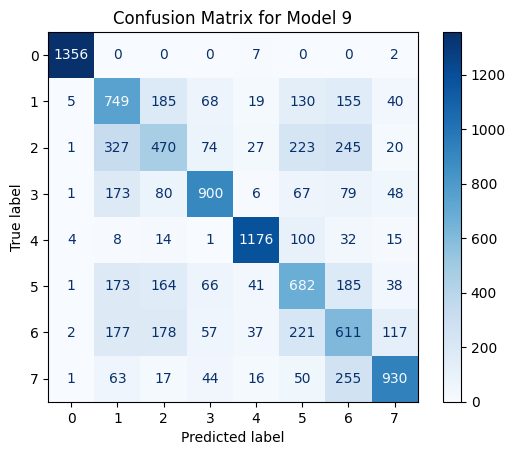

In [35]:
#Specify the model (for the title)
model_name = "Model 9"

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(8)])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Very nice, but the labels are not clear when displayed in a numeric format, so let's add the string versions of the labels.

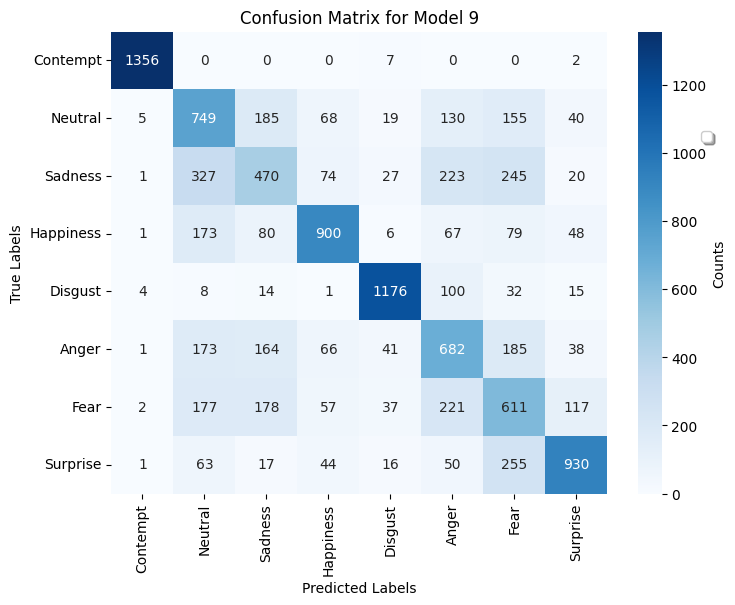

In [36]:
#Specify the model (for the title)
model_name = "Model 9"

# Label mapping
label_mapping = {
    0: 'Contempt',
    1: 'Neutral',
    2: 'Sadness',
    3: 'Happiness',
    4: 'Disgust',
    5: 'Anger',
    6: 'Fear',
    7: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

We can see that some emotions were much easier to recognize compared to others. For example we have a high level of accuracy with Contempt and Disgust. Accordingly, the two datasets were much smaller, so even if applied image augmentation, it means that either the images had a higher quality in how emotions were accurately represented, or it may mean overfitting (because of the small starting dataset).

We can see that other emotions like Surprise and Fear (as expected), Nutral and Sadness or Sadness and Fear, or Anger and Fear were confused with each other many times. Surprisingly Surprise and Happines did not get confused much.

Some of the confusion was probably fostered by the quality of the data (see [Conclusions](#conclusions)). Also the fact that some emotions have similar traits made the learning process more difficult (e.g., Neutral Vs Sadness), and it would be useful to use this generic model as a base model to train more specialized models aimed at detecting the difference between such emotions (through the identification of microexpressions).

## Conclusions

Despite it has slightly lower accuracy than Model 1, the slower and more stable increment in accuracy suggests that Model 2 and 9 are more resistent to overfitting (the only difference is that the former has 0.25 dropout rate and the latter 0.5). Even if the big gap between training and test accuracy suggests some overfitting in both, Model 1 seems to be overfitting much more. This is also because the model converges very rapidly. So, it looks like adding some hidden layer with dropout improved the performance of the model. In the future, we can try by adding more hidden layers with 0.5 dropout rate or higher to reduce overfitting.

Below you can find the architecture of the best model in this notebook.

In [27]:
model_9 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_9.to(device)

# Summarize the model
summary(model_9, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14              

Our best model reached around 63.5% of accuracy on the test set, which is not ideal, but still got the right asnwer the majority of the times with 8 classes to choose from.

We trained and tested 8 separate model to find out that:
1. Adding too many hidden layers reduced the performance of the model, but adding none made the model more prone to overfitting. If we had to build the models again, we would try adding just one or two hidden layers at a time to asses the changes in performance while saving computational power.
2. Reducing the number of convolutional layers reduced the test accuracy.
3. Reducing the dropout also reduced the test accuracy, whereas increasing the dropout reduced overfitting.
4. Adding weight decay and betas slightly improved performance.

We have seen that, even if there may be still routes that could lead us to improve the model performance by tweaking layers and dropout, that's now where we should focus next. Where we should focsu is in fine tuning the hyperparameters of the optimized, such as the learning rate, weight decay and the betas. We could also change the activation functions iside of the model and the optimizer, and see what happen, even if the RELU function and Adam optimizer are usually the default choices for these kind of tasks. We can also try to change the batch size in the dataloaders, which was 32 in this notebook. However, batch size usually has much bigger effects on RNN, especially dealing with time series data, compared to CNN.

We also found out that by randomly creating new training, test, and validation sets, chagned the performance of the models of 1-2 percentage points. This means that the quality of the data is a major bottleneck in this experiemnt. As said in the first notebook of the series, if there are missclassified images in the original data, that may lead to errors in the training. Also, mixed emotions (e.g., surprise + fear, surprise + happiness) can confuse the model as well. Also the fact that some emotions have similar traits made the learning process more difficult (e.g., Neutral Vs Sadness), and it would be useful to use this generic model as a base model to train more specialized models aimed at detecting the difference between such emotions (through the identification of microexpressions).

Another challenge was that the majority of images were images portraing actors interpreting an emotion. While it looks like the majortiy of good actors did a good job in displaying the emotion, some representation may not have looked authentic, with incomplete and to genuine microexpressions. To reduce the risk of encountering these two challenges we could access to bigger datasets (to increasing the chance of good samples outnumbering bad samples), and higher quality more controlled datasets. A further study could also take the output model from this study and use it as a pre-trained model to classify genuine Vs faked emotions from pictures.

When loading the data we removed duplicates, mixed data from different sources (increasing the variance in gender, etnic diversity, angles, and styles), and augmented data to reduce overfitting and balance the classes, so each class got the same amount of items. However, we did not aumented the images from the "Happiness" folder, because it had the most items, so further study could do some augmentation there too to reduce overfitting (still making sure that each label has the same number of items).